# Scalp Type Image Classifier using ResNet152v2 

In [6]:
!pip install opencv-python


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob 
import tensorflow as tf
import PIL
from PIL import ImageDraw

from tensorflow.keras import models
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten, Activation, BatchNormalization,Input,Add,ZeroPadding2D,AveragePooling2D,GlobalMaxPooling2D,MaxPool2D
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet_v2 import ResNet152V2,ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions


from sklearn.metrics import confusion_matrix

Train_data, Validation, Test >> dandruff, erythema, hairloss, folliculitis, oily_scalp, dry_scalp 총 6가지 두피 타입 이미지 데이터셋이 있음

In [2]:
train_dir = 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\train'
valid_dir = 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\validation'
test_dir = 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\test'

------------------------------

### Image generator

In [7]:
# image labels

labels=pd.Series(os.listdir(train_dir))

labels=labels.sort_values()
labels=labels.to_list()
labels

['folliculitis_0', 'folliculitis_1', 'folliculitis_2', 'folliculitis_3']

In [8]:
image_height = 224  # 이미지 높이
image_width = 224   # 이미지 넓이
batch_size = 32     # batch size
epochs  = 20  # trining 횟수

In [9]:
# ImageDataGenerator 클래스를 통해 train_datagen, val_datagen 인스턴스를 생성.
# 픽셀 값을 0~1 범위로 변환

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [106]:
# train_datagen 인스턴스를 통해 train dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 training_set 객체를 생성.
train_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(image_width, image_height),
                                                 
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


# val_datagen 인스턴스를 통해 test dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_set 객체를 생성.
test_set = test_datagen.flow_from_directory(test_dir,
                                            
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='categorical')

#val_datagen 인스턴스를 통해 val dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 val_set 객체를 생성.
val_set = val_datagen.flow_from_directory(valid_dir,
                                          
                                           target_size=(image_width, image_height),
                                           batch_size=batch_size,
                                           class_mode='categorical')

Found 8446 images belonging to 4 classes.
Found 534 images belonging to 4 classes.
Found 1333 images belonging to 4 classes.


In [105]:
print(np.shape(train_set[3][3]))

IndexError: tuple index out of range

In [110]:
train_set[-2]

(array([[[[0.29411766, 0.32941177, 0.24705884],
          [0.3529412 , 0.38823533, 0.30588236],
          [0.37254903, 0.40784317, 0.33333334],
          ...,
          [0.7176471 , 0.72156864, 0.7372549 ],
          [0.6117647 , 0.60784316, 0.627451  ],
          [0.5647059 , 0.56078434, 0.5803922 ]],
 
         [[0.34509805, 0.37647063, 0.29411766],
          [0.34117648, 0.37254903, 0.2901961 ],
          [0.32156864, 0.34901962, 0.2784314 ],
          ...,
          [0.57254905, 0.5764706 , 0.5921569 ],
          [0.45882356, 0.454902  , 0.47450984],
          [0.4156863 , 0.41176474, 0.43137258]],
 
         [[0.32941177, 0.34117648, 0.25882354],
          [0.34117648, 0.3529412 , 0.2784314 ],
          [0.3372549 , 0.3529412 , 0.28627452],
          ...,
          [0.39607847, 0.41176474, 0.4156863 ],
          [0.3137255 , 0.31764707, 0.3254902 ],
          [0.2901961 , 0.29411766, 0.3019608 ]],
 
         ...,
 
         [[0.86666673, 0.8745099 , 0.8313726 ],
          [0.85490

In [107]:
from matplotlib.pyplot import imshow
%matplotlib inline
for i in range(len(train_set)-1):
    for j in range(32):
    
        ii=np.zeros([224,224,3])
        ii=train_set[i][0][j]
        
        dd=ii*255
        dst1= cv2.inRange(dd, (100, 100, 0), (255, 255, 255))
        train_set[i][0][j] = cv2.bitwise_and(ii, ii, mask=dst1)


IndexError: index 30 is out of bounds for axis 0 with size 30

In [111]:
from matplotlib.pyplot import imshow
%matplotlib inline
for i in range(len(val_set)-1):
    for j in range(32):
    
        ii=np.zeros([224,224,3])
        ii=val_set[i][0][j]
        
        dd=ii*255
        dst1= cv2.inRange(dd, (100, 100, 0), (255, 255, 255))
        val_set[i][0][j] = cv2.bitwise_and(ii, ii, mask=dst1)

In [113]:
class_path = glob.glob(train_dir + '/*')
class_path

['D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\train\\folliculitis_0',
 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\train\\folliculitis_1',
 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\train\\folliculitis_2',
 'D:\\빅데이터기반지능형서비스개발\\07기업요구사항기반의문제해결pjt\\tdata\\train\\folliculitis_3']

In [114]:
# 각각의 data set 이 만들어 내는 이미지의 클래스 인덱스 확인
print(f'train set의 이미지 클래스: {train_set.class_indices}')
print(f'test set의 이미지 클래스: {test_set.class_indices}')
print(f'validation set의 이미지 클래스: {val_set.class_indices}')

train set의 이미지 클래스: {'folliculitis_0': 0, 'folliculitis_1': 1, 'folliculitis_2': 2, 'folliculitis_3': 3}
test set의 이미지 클래스: {'folliculitis_0': 0, 'folliculitis_1': 1, 'folliculitis_2': 2, 'folliculitis_3': 3}
validation set의 이미지 클래스: {'folliculitis_0': 0, 'folliculitis_1': 1, 'folliculitis_2': 2, 'folliculitis_3': 3}


In [115]:
classNum = []
fileNum = []
for path in class_path :
    fileNum.append(len(glob.glob(path + '/*')))
    classNum.append(int(path.split('_')[-1]))

label_dic = dict(zip(classNum, fileNum))
label_dic

{0: 2022, 1: 2126, 2: 2157, 3: 2141}

### 모델링

In [118]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2,ResNet50V2, preprocess_input, decode_predictions

conv_base = ResNet50V2(include_top=False, weights = 'imagenet' ,input_shape=(224,224,3))
conv_base.trainable = False
conv_base.summary()


94674944/94668760 [==============================] - 7s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________

In [119]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 36,410,500
Trainable params: 12,845,700
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
for i, layer in enumerate(conv_base.layers) :
  print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 pool1_pad
4 pool1_pool
5 conv2_block1_preact_bn
6 conv2_block1_preact_relu
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_pad
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_out
17 conv2_block2_preact_bn
18 conv2_block2_preact_relu
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_pad
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_out
28 conv2_block3_preact_bn
29 conv2_block3_preact_relu
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_pad
34 conv2_block3_2_conv
35 conv2_block3_2_bn
36 conv2_block3_2_relu
37 max_pooling2d
38 conv2_block3_3_conv
39 conv2_block3_out
40 conv3_block1_preact_bn
41 conv3_block1_preact_relu
42 conv3_block1_1_conv
43 conv3_block1_1_bn
44 conv3_block1_1_relu
45 conv3_block1_2_pad
46 

In [23]:
for layer in conv_base.layers[528:] :
  layer.trainable = True

In [24]:
# model.summary()

In [120]:
# optimizer 정의

opt = tf.keras.optimizers.Adam(learning_rate= 0.0001,beta_1=0.9, beta_2=0.999,epsilon=1e-07)

In [122]:
# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint('logs/f_resnet_1.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_acc', patience=7)

# callback 정의
callbacks= [modelCheckpoint,monitor_val_acc]

In [123]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['acc'])

In [124]:
resnet152v2_history =model.fit(train_set,
                    steps_per_epoch=2400//batch_size,
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=800//batch_size,
                    callbacks=callbacks
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 25 steps
Epoch 1/20
75/75 [==============================] - 21s 278ms/step - loss: 1.3014 - acc: 0.4771 - val_loss: 1.5708 - val_acc: 0.4225
Epoch 2/20
75/75 [==============================] - 11s 152ms/step - loss: 0.7849 - acc: 0.6733 - val_loss: 2.0209 - val_acc: 0.4225
Epoch 3/20
75/75 [==============================] - 11s 151ms/step - loss: 0.6622 - acc: 0.7250 - val_loss: 1.6414 - val_acc: 0.4688
Epoch 4/20
75/75 [==============================] - 11s 151ms/step - loss: 0.4704 - acc: 0.8244 - val_loss: 1.8978 - val_acc: 0.4625
Epoch 5/20
75/75 [==============================] - 11s 151ms/step - loss: 0.4788 - acc: 0.8215 - val_loss: 1.7098 - val_acc: 0.4625
Epoch 6/20
75/75 [==============================] - 11s 151ms/step - loss: 0.3672 - acc: 0.8625 - val_loss: 2.3688 - val_acc: 0.4350
Epoch 7/20
75/75 [==============================] - 11s 151ms/step - loss: 0.3140 - acc: 0.8908 - val_loss: 2.

KeyboardInterrupt: 

In [ ]:
# resnet_model 모델 평가
(test_loss, test_accuracy) = model.evaluate(test_set, steps=800//batch_size, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy*100)

25/25 [==============================] - 236s 10s/step - loss: 2.2713 - acc: 0.4162
Test loss: 2.2713210582733154
Test accuracy: 41.624999046325684


In [ ]:
# font 설정

font1 = {'family': 'DejaVu Sans',
         'weight': 'bold',
         'size': 20
         }

font2 = {'family': 'DejaVu Sans',
         'size': 16
         }   

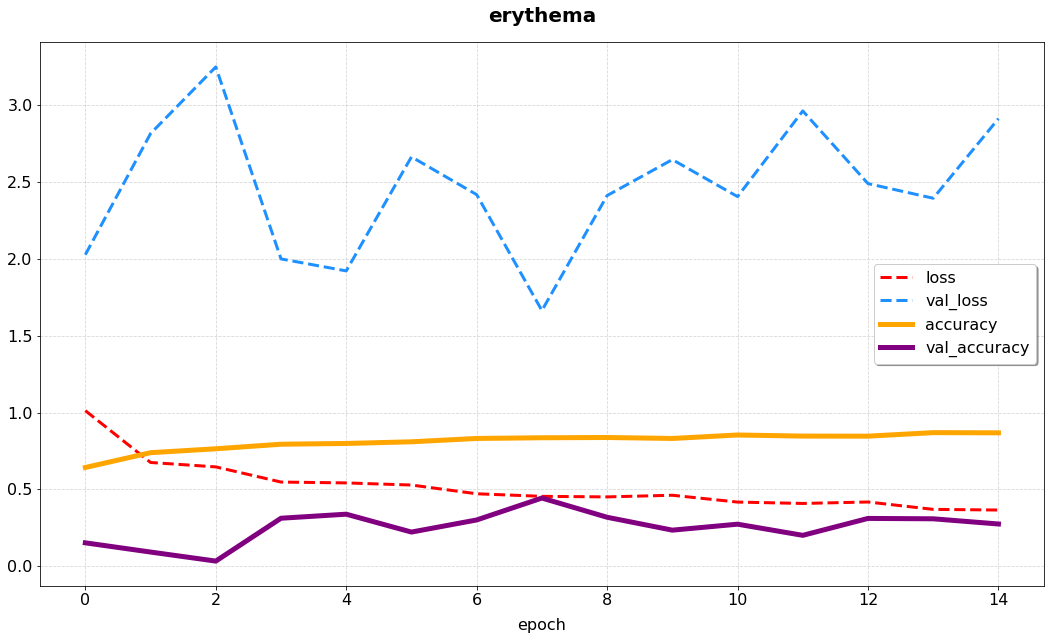

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(resnet152v2_history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(resnet152v2_history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(resnet152v2_history.history['acc'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(resnet152v2_history.history['val_acc'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('erythema', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_set)
classes = test_set.classes[test_set.index_array]
y_pred = np.argmax(Y_pred, axis=1)

result_dict = dict(map(reversed, test_set.class_indices.items()))
class_names = list(result_dict.values())

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))

print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))

In [ ]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d' )
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title(f'{subject}_confusion matrix')